## модель ФЧ ДРП

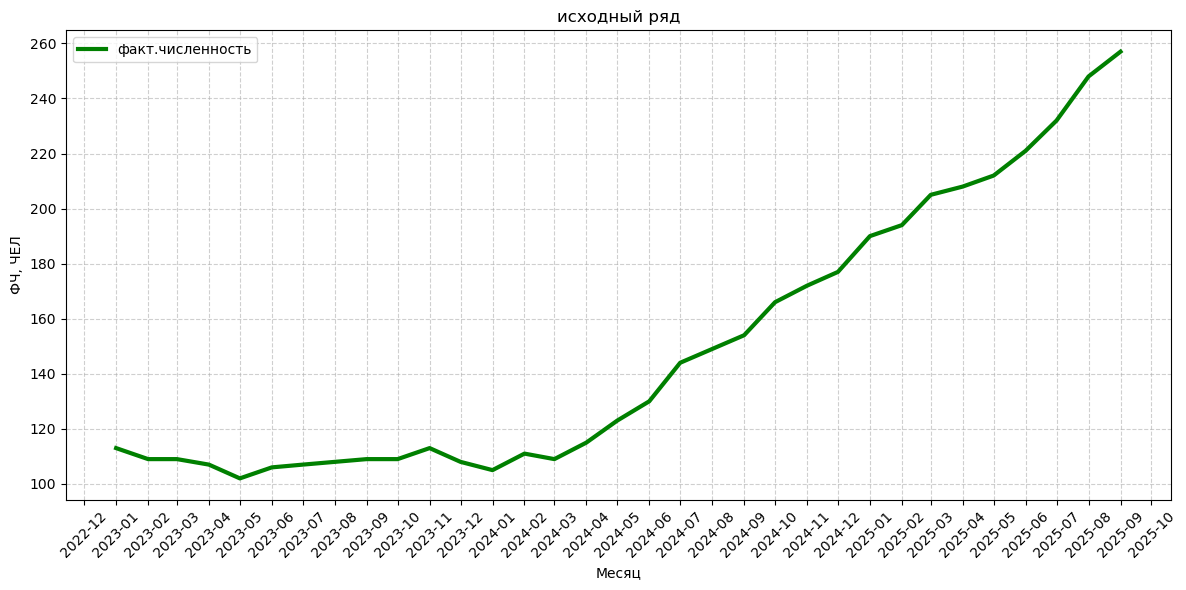

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#ЗАВОДИМ ДАННЫЕ
df = pd.read_excel('fact_drp.xlsx')
colums_list = df.columns.tolist()

df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['total'] = pd.to_numeric(df['total'], errors='coerce')

# СТРОИМ ГРАФИК
df = df.dropna(subset=['date', 'total']).set_index('date').asfreq('MS')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['total'], label='факт.численность', linewidth=3, color = 'green')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('исходный ряд')
ax.set_xlabel('Месяц'); ax.set_ylabel('ФЧ, ЧЕЛ')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


### стационарность

In [9]:
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("РЯД НЕ СТАЦИОНАРЕН")
    else:
        print("РЯД СТАЦИОНАРЕН")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['total'], 'Counts')


Results of ADF Test on Counts:
ADF Statistic: 4.20520546906326
p-value: 1.0
РЯД НЕ СТАЦИОНАРЕН
Critical Value (1%): -3.653519805908203
Critical Value (5%): -2.9572185644531253
Critical Value (10%): -2.6175881640625




### трейн и тест

In [12]:
train_size = int(len(df) * 0.80)

train = df.iloc[:train_size]   # 
test  = df.iloc[train_size:]   # 

print("Размер train:", train.shape)
print("Размер test :", test.shape)

Размер train: (26, 1)
Размер test : (7, 1)


### дифф 1

In [ ]:
train_diff1 = train["total"].diff().dropna()

print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

train_diff1.plot()

### дифф 2

In [ ]:
train_diff2 = train["total"].diff().diff().dropna()

print("ADF p-value после 2 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff2, "Train after 1st diff")

train_diff1.plot()

### дифф 3

In [ ]:
train_diff3 = train["total"].diff().diff().diff().dropna()

print("ADF p-value после 3 diff:", adfuller(train_diff3)[1])
test_stationarity(train_diff3, "Train after 2nd diff")
train_diff3.plot()

### ACF - q

<Figure size 800x400 with 0 Axes>

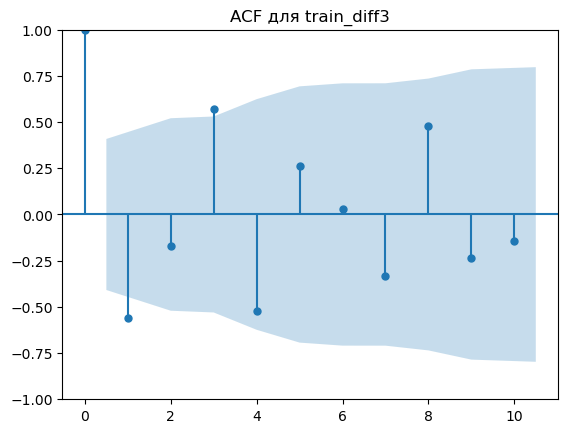

In [91]:
plt.figure(figsize=(8,4))
plot_acf(train_diff3, lags=10)
plt.title("ACF для train_diff3")
plt.show()

### PACF - p

In [ ]:
plt.figure(figsize=(8,4))
plot_pacf(train_diff3, lags=10, method="ywm")  # "ywm" – более устойчивая оценка
plt.title("PACF для train_diff3")
plt.show()

### ARIMA (тест модели)

In [ ]:
p = 1
d = 3
q = 1

model = ARIMA(train["total"], order=(p, d, q))
print('--------------------')
model_fit = model.fit()
print('--------------------')
print(model_fit.summary())

#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["total"] - forecast) / test["total"])) * 100
print('--------------------')
print(f"MAPE: {mape:.2f}%")

#проверка MAE
y_true = test["total"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print('--------------------')
print(f"MAE: {mae:.2f}")

#печать прогнозных значений
forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print('--------------------')
print (forecast)

plt.figure(figsize=(12,6))
plt.plot(train.index, train["total"], label="Обучающая выборка", linewidth=3, color="green")
plt.plot(test.index, test["total"], label="Тестовая выборка", linewidth=3, color="y")
plt.plot(test.index, forecast, label="Прогноз", linewidth=3, linestyle='--', color="blue")

plt.title("ПРОВЕРКА МОДЕЛИ -- ПРОГНОЗ VS ТЕСТ")
plt.xlabel("Дата")
plt.ylabel("ФЧ, ЧЕЛ.")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### ARIMA (прогноз)

--------------------
                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                   33
Model:                 ARIMA(1, 3, 1)   Log Likelihood                 -91.901
Date:                Thu, 18 Sep 2025   AIC                            189.803
Time:                        22:10:51   BIC                            194.006
Sample:                    01-01-2023   HQIC                           191.147
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5487      0.180     -3.046      0.002      -0.902      -0.196
ma.L1         -0.9998    102.293     -0.010      0.992    -201.490     199.490
sigma2        22.9752   2351.93

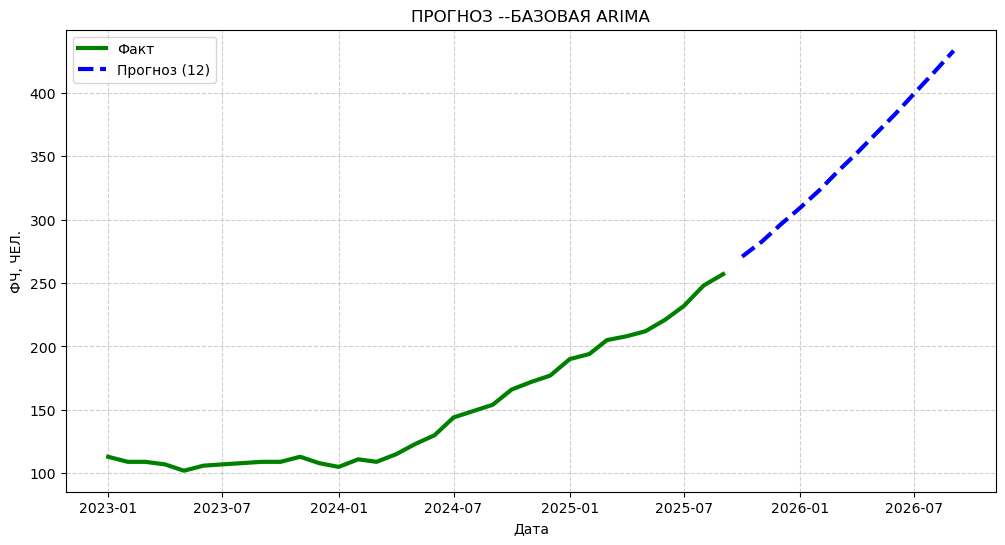

In [73]:
p = 1
d = 3
q = 1

model = ARIMA(df["total"], order=(p, d, q))
model_fit = model.fit()
print('--------------------')
print(model_fit.summary())

s = pd.to_numeric(df["total"], errors="coerce").dropna() 
s.index = pd.to_datetime(df.index) # если уже datetime — ок 
freq = pd.infer_freq(s.index) 
if freq is None: 
    freq = "MS" 
s = s.asfreq(freq).interpolate() 

model = ARIMA(s, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False) 
model_fit = model.fit()
print('----------------') 
print(model_fit.summary())

fc = model_fit.get_forecast(steps=12) 
yhat = fc.predicted_mean # значения прогноза ci = fc.conf_int() # доверительные интервалы

#print("\nПрогноз на 12 периодов:") 
#print(yhat)

plt.figure(figsize=(12,6)) 
plt.plot(s.index, s.values, label="Факт", linewidth=3, color = 'green') 
plt.plot(yhat.index, yhat.values, label="Прогноз (12)", linewidth=3, color = 'blue', linestyle='--') 

plt.title("ПРОГНОЗ --БАЗОВАЯ ARIMA") 
plt.xlabel("Дата"); 
plt.ylabel("ФЧ, ЧЕЛ.") 
plt.legend(); 
plt.grid(True, linestyle="--", alpha=0.6) 
plt.show()

### ARIMA (прогноз, ограничитель)


Прогноз (c ограничением):
2025-10-01    270.820860
2025-11-01    282.491891
2025-12-01    296.123666
2026-01-01    309.292204
2026-02-01    323.426913
2026-03-01    337.684880
2026-04-01    350.000000
2026-05-01    350.000000
2026-06-01    350.000000
2026-07-01    350.000000
2026-08-01    350.000000
2026-09-01    350.000000
Freq: MS, Name: predicted_mean, dtype: float64


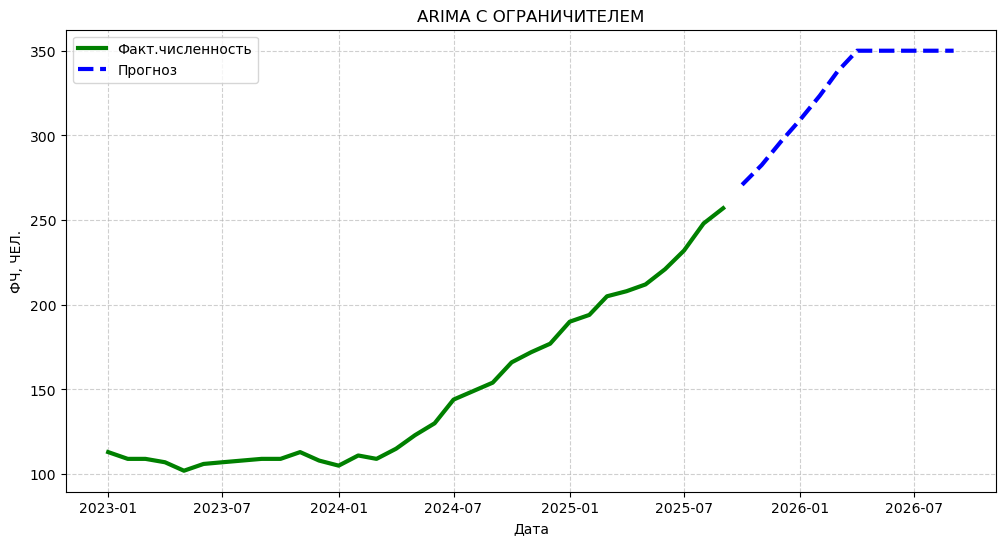

In [78]:
CAP = 350 
HALF_YEAR = 6 

yhat = fc.predicted_mean.copy() 
ci = fc.conf_int()



reached = (yhat >= CAP).values 
yhat_capped = yhat.copy()

if reached.any(): 
    first_hit_pos = int(np.argmax(reached)) # позиция первого превышения 
    if first_hit_pos < HALF_YEAR: # если достигли порога в первые 6 месяцев — дальше плоско на CAP 
        yhat_capped.iloc[first_hit_pos:] = CAP 
    else: # если порог достигнут позже 6 мес — просто не даём превысить 
        yhat_capped = yhat_capped.clip(upper=CAP) 
else: # порог в горизонте не достигнут — на всякий случай не превышаем порог 
        yhat_capped = yhat_capped.clip(upper=CAP)
        
#---- печать и график с ограничением ----
print("\nПрогноз (c ограничением):") 
print(yhat_capped)

plt.figure(figsize=(12,6)) 
plt.plot(s.index, s.values, label="Факт.численность", linewidth=3, color = 'green') 
plt.plot(yhat.index, yhat_capped.values, label=f"Прогноз", linewidth=3, color = 'blue', linestyle='--' ) 
plt.title(f"ARIMA С ОГРАНИЧИТЕЛЕМ") 
plt.xlabel("Дата"); plt.ylabel("ФЧ, ЧЕЛ.") 
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6) 
plt.show()


### Prophet

In [85]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:11 - cmdstanpy - INFO - Chain [1] done processing


MAE : 3.62
MAPE: 1.71%


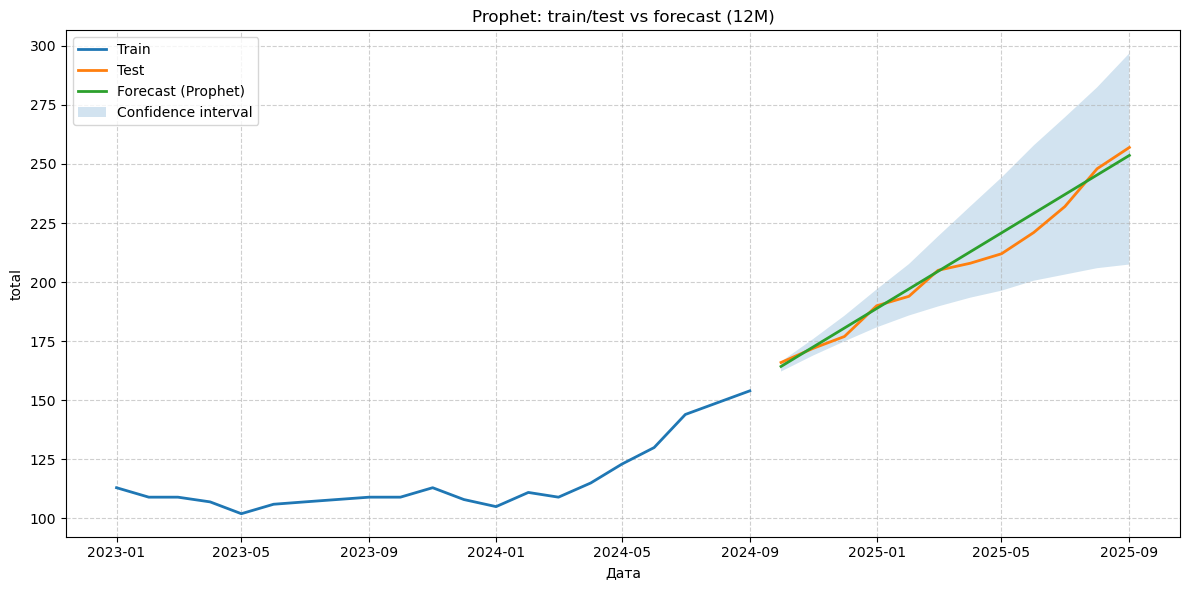

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# --- 1) Загрузка и подготовка ---
df = pd.read_excel("fact_drp.xlsx")
df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['total'] = pd.to_numeric(df['total'], errors='coerce')
df = df.dropna(subset=['date','total']).sort_values('date')

# гарантируем месячную частоту (опционально, если есть пропуски месяцев)
# df = df.set_index('date').asfreq('MS').reset_index()

# prophet-формат
data = df.rename(columns={'date':'ds', 'total':'y'})

# --- 2) Трейн/тест: последние 12 мес = тест ---
horizon = 12
train = data.iloc[:-horizon].copy()
test  = data.iloc[-horizon:].copy()

# --- 3) Модель Prophet ---
# для месячных рядов выключаем недельную/дневную сезонность
m = Prophet(
    growth='linear',
    yearly_seasonality='auto',
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,   # можно ослабить/усилить гибкость тренда (0.05..1.0)
    seasonality_mode='additive'    # при ускоряющемся росте попробуй 'multiplicative'
)

m.fit(train)

# --- 4) Прогноз на 12 месяцев вперёд ---
future = m.make_future_dataframe(periods=horizon, freq='MS')  # 'MS' = Month Start
forecast = m.predict(future)

# --- 5) Берём только прогнозный горизонт и считаем метрики ---
fcst_tail = forecast.tail(horizon).copy()
y_true = test['y'].to_numpy(dtype=float)
y_pred = fcst_tail['yhat'].to_numpy(dtype=float)

mae  = np.mean(np.abs(y_true - y_pred))
# защита от деления на ноль
denom = np.where(y_true == 0, np.nan, y_true)
mape = np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- 6) Визуализация ---
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train', linewidth=2)
plt.plot(test['ds'],  test['y'],  label='Test', linewidth=2)
plt.plot(fcst_tail['ds'], fcst_tail['yhat'], label='Forecast (Prophet)', linewidth=2)

# доверительный интервал Prophet (по умолчанию 80% или 95% в зависимости от версии; можно изменить m.interval_width)
plt.fill_between(
    fcst_tail['ds'],
    fcst_tail['yhat_lower'],
    fcst_tail['yhat_upper'],
    alpha=0.2, label='Confidence interval'
)

plt.title("Prophet: train/test vs forecast (12M)")
plt.xlabel("Дата")
plt.ylabel("total")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7) (опционально) компоненты модели ---
# m.plot_components(forecast); plt.show()
